In [3]:
from copy import deepcopy
import datetime
import os
import pickle
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from multihist import Hist1d, Histdd
from tqdm.notebook import tqdm
import pandas as pd
from scipy import stats

import strax
import straxen
strax.utils.tqdm = tqdm # use notebook-aware progress bar

st = straxen.contexts.xenonnt_online()
st.context_config['check_available'] = ('raw_records','pulse_counts','peaklets','lone_hits')
st.data_info('lone_hits')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,area,float32,Integral [ADC x samples]
5,left,int16,Index of sample in record in which hit starts
6,right,int16,Index of first sample in record just beyond hi...
7,left_integration,int16,"For lone hits, index of sample in record where..."
8,right_integration,int16,"For lone hits, index of first sample beyond in..."
9,record_i,int32,Internal (temporary) index of fragment in whic...


In [4]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
matplotlib.rcParams['axes.linewidth'] = 0.75 #set the value globally
matplotlib.rcParams['xtick.major.width'] = 0.75
matplotlib.rcParams['ytick.major.width'] = 0.75
matplotlib.rcParams['axes.labelsize'] = 7
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.labelsize'] = 6
matplotlib.rcParams['ytick.labelsize'] = 6
matplotlib.rcParams['legend.fontsize'] =5
matplotlib.rcParams['pdf.fonttype']=42


matplotlib.rcParams['figure.figsize'] = (3.4908516673585166, 2.327234444905678)
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rc('font', size= 7)
params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
plt.rcParams.update(params)

Define Fit Function

In [5]:
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import operator

def func(x, N0, a, s0, N1, m1, s1, N2, s2):
    g0 = N0 * np.exp(-(x-m1*a)**2/(s0**2))
    g1 = N1 * np.exp(-(x-m1)**2/(s1**2))
    g2 = N2 * np.exp(-(x-m1*2)**2/(s2**2))
    return g0+g1+g2

Npar = 8

def SingleGauss(x, N, m, s):
    g = N * np.exp(-(x-m)**2/(s**2))
    return g

In [6]:
def channel_check(run, channel, check):
    counter = 0
    
    run_info = st.select_runs(run_id=run)
    run_time = 1000#run_info['livetime'].values[0]/np.timedelta64(1,'s')
    N_int = 10
    size_s = run_time/N_int
#    print(run_time) 
    times =[]
    val = []
    err = [] 
    rate = []
    for c in np.arange(0, run_time, size_s):
        
        data=st.get_df(run,'lone_hits',selection_str=channel, seconds_range=(c,c+size_s))
        h0 = Hist1d(data['area'],bins=400, range=(0,800)) 
        
        Max_index, Max_value = max(enumerate(h0.histogram), key=operator.itemgetter(1))
        Max_x = h0.bin_centers[Max_index]
        
        pfit, pcov = curve_fit(func, h0.bin_centers, h0.histogram, bounds=([1,0,0, 1,0.75*Max_x,0,  1,0], [5000,0.8,100, 10000,1.25*Max_x, 300,  10000,300]),)
        error = [] 
        for i in range(len(pfit)):
            try:
                error.append(np.absolute(pcov[i][i])**0.5)
            except:
                error.append( 0.00 )
        pfit_curvefit = pfit
        perr_curvefit = np.array(error)
        
        if c == 0 and check == True:
            print(pfit_curvefit)
            print(perr_curvefit)
            h0.plot(color='black')
            plt.plot(h0.bin_centers, func(h0.bin_centers, *pfit), linestyle='solid', c='red',label='N0=%5.3f, a=%5.3f, s0=%5.3f, \n N1=%5.3f, m1=%5.3f, s1=%5.3f, \n N2=%5.3f, s2=%5.3f ' % tuple(pfit))
            plt.plot(h0.bin_centers, SingleGauss(h0.bin_centers, *pfit[3:6]), linestyle='dashed', c='green')
            plt.plot(h0.bin_centers, SingleGauss(h0.bin_centers, pfit[0],pfit[1]*pfit[4],pfit[2]),  linestyle='dashed', c='blue')
            plt.plot(h0.bin_centers, SingleGauss(h0.bin_centers, pfit[6],2.*pfit[4],pfit[7]),  linestyle='dashed', c='orange')

            plt.legend(loc='upper right')
            plt.show()
                
        chisq = sum( ((h0.histogram[i] - func(h0.bin_centers[i], *pfit)) / np.sqrt(h0.histogram[i]))**2 for i in  np.arange(0,len(h0.histogram)) if h0.histogram[i] != 0)
        Nbin0 = sum(1 for i in  np.arange(0,len(h0.histogram)) if h0.histogram[i] != 0)
        #print(chisq,' ',Nbin0)
        Ndof = Nbin0 - Npar
        
        times.append(c+size_s/2)
        val.append(pfit_curvefit[4])
        err.append(perr_curvefit[4])
        
        hm = Hist1d(data['area'],bins=200, range=(pfit[4]-pfit[5],pfit[4]+pfit[5])) 
        rate.append(hm.cumulative_histogram[199]/size_s)

        if check == True:
            print('----------------------------')
            print(data['time'][0]/1.e9)
            counter = counter +1
            print(counter,' Fit Parameters:')
            print('SPE peak: ', pfit_curvefit[4], '\pm', perr_curvefit[4] )
            print('chi^2/Ndof = ',chisq/Ndof)
            print("1 sigma interval rate = ",hm.cumulative_histogram[199]/size_s, ' events/s')
     
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    ax.errorbar(times, val, err,0, marker='.', markersize=2, linestyle="" , linewidth=0.5, color='red',label='SPE peak vs Time')
    ax.set_xlabel('Time [s]')
    ax.set_ylim(0.95*val[0],1.05*val[0])
    ax.legend(frameon=False, loc='upper left')
         
    fig = plt.figure(2)
    ax = fig.add_subplot(111)
    ax.plot(times, rate, marker='.', markersize=2, linestyle="" , linewidth=0.5, color='red',label='SPE peak rate vs Time')
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Rate[events/s]')
    ax.set_ylim(0.95*rate[0],1.05*rate[0])
    ax.legend(frameon=False, loc='upper left')
    plt.show()
    
        

Select Run and Channel

In [7]:
run_id = '007730'
selection_str = '(channel == 300) & (channel == 300)' 

The flag "check" is used to have printed on the screen results one by one

Checking data availability: 100%|██████████| 4/4 [04:12<00:00, 63.03s/it]


[7.98688417e+01 2.62791053e-01 7.72791746e+01 2.71429953e+02
 3.86819800e+02 1.53620378e+02 7.09201054e+01 1.09023219e-03]
[2.09806053 0.00461591 2.81080153 1.50356738 0.74932598 1.17358899
 0.         0.        ]


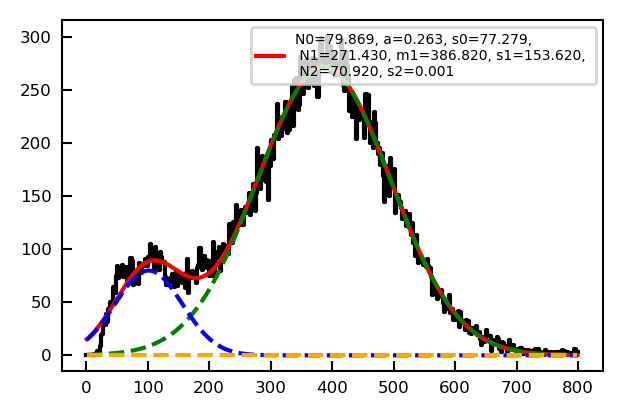

----------------------------
1589632300.0079658
1  Fit Parameters:
SPE peak:  386.8198001023282 \pm 0.7493259811191368
chi^2/Ndof =  4.071464705748448
1 sigma interval rate =  311.39  events/s
----------------------------
1589632400.0006793
2  Fit Parameters:
SPE peak:  386.80240477109095 \pm 0.7684276446936288
chi^2/Ndof =  4.12947343182707
1 sigma interval rate =  308.39  events/s
----------------------------
1589632500.0009403
3  Fit Parameters:
SPE peak:  385.0537762559102 \pm 0.7850945789476695
chi^2/Ndof =  4.35751488561469
1 sigma interval rate =  306.91  events/s
----------------------------
1589632600.0026717
4  Fit Parameters:
SPE peak:  385.50027192931196 \pm 0.7420751424241677
chi^2/Ndof =  4.267036906843879
1 sigma interval rate =  312.64  events/s
----------------------------
1589632700.005317
5  Fit Parameters:
SPE peak:  385.94066726699907 \pm 0.7324724573418387
chi^2/Ndof =  4.631686459399612
1 sigma interval rate =  305.39  events/s
----------------------------
158963

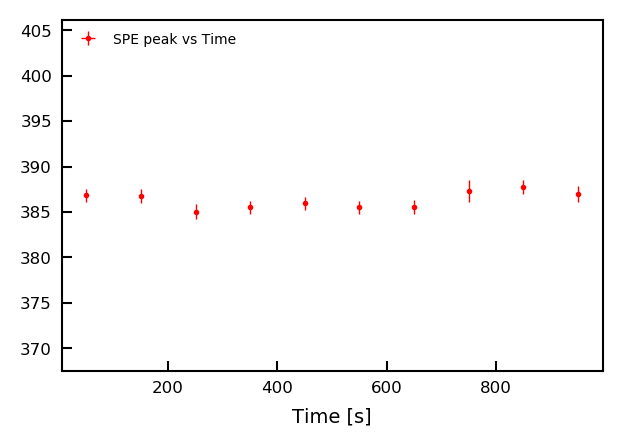

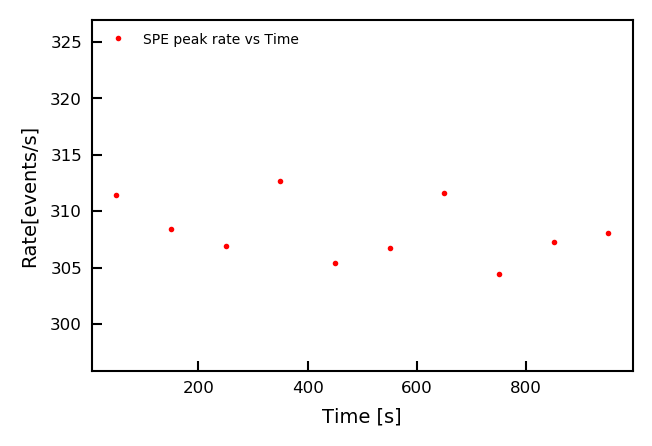

In [8]:
channel_check(run_id,selection_str,True)

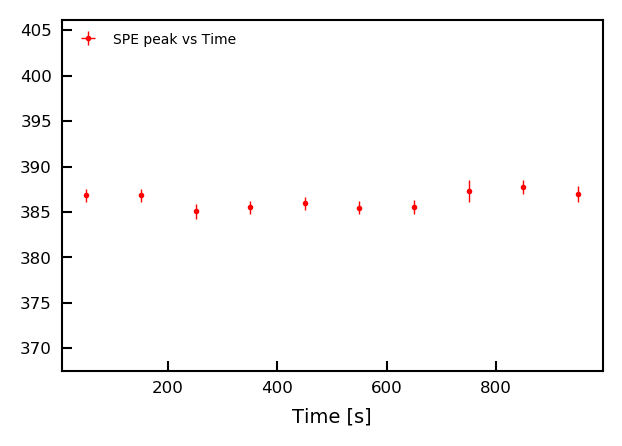

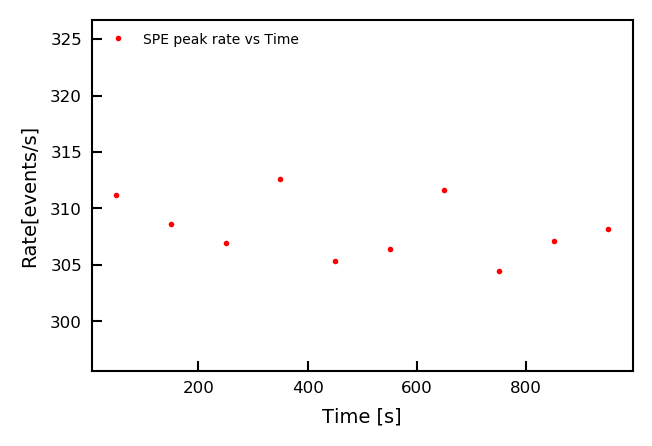

In [24]:
channel_check(run_id,selection_str,False)

## Example with Loop on Runs

[ 59.27957263   0.34271869  43.93341221 289.06170519 233.29169716
 108.16959119   2.15547099  67.95405989]
[2.66704867e+00 6.57538269e-03 2.43855471e+00 1.52627409e+00
 6.10510846e-01 1.05103932e+00 1.80032442e+00 7.36832105e+01]


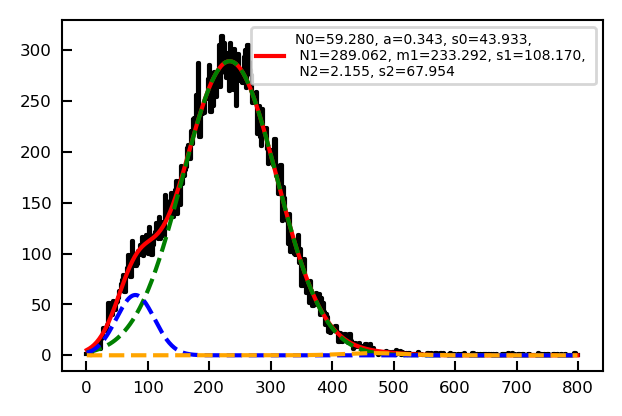

----------------------------
1589632300.0000744
1  Fit Parameters:
SPE peak:  233.29169715827348 \pm 0.6105108463862176
chi^2/Ndof =  1.4593368199388808
1 sigma interval rate =  235.27  events/s
----------------------------
1589632400.0016305
2  Fit Parameters:
SPE peak:  232.75199941771828 \pm 0.595073622970466
chi^2/Ndof =  2.1644758509623045
1 sigma interval rate =  234.25  events/s
----------------------------
1589632500.0095732
3  Fit Parameters:
SPE peak:  231.1165233728837 \pm 0.4928223515464865
chi^2/Ndof =  1.2589890821017182
1 sigma interval rate =  235.96  events/s
----------------------------
1589632600.0112813
4  Fit Parameters:
SPE peak:  232.69377606419815 \pm 0.6503130788531297
chi^2/Ndof =  1.2000631618128104
1 sigma interval rate =  231.0  events/s
----------------------------
1589632700.001573
5  Fit Parameters:
SPE peak:  234.60322409989226 \pm 0.5406713004719637
chi^2/Ndof =  1.65488271391473
1 sigma interval rate =  232.88  events/s
----------------------------
15

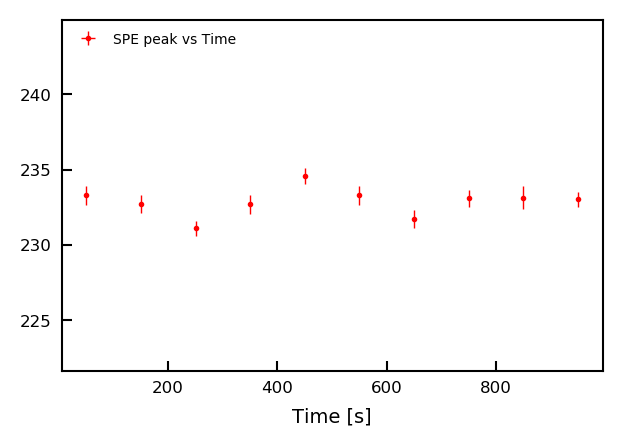

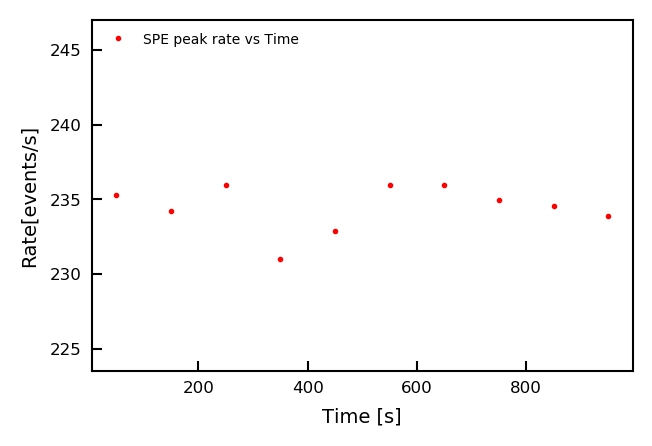

[ 57.99331915   0.34473049  45.62348923 288.5627167  232.3854226
 106.61497593   3.39847035 124.47987548]
[2.41738305e+00 6.45249499e-03 2.35370607e+00 1.43860965e+00
 6.14966613e-01 9.67162272e-01 1.27269319e+00 6.63885911e+01]


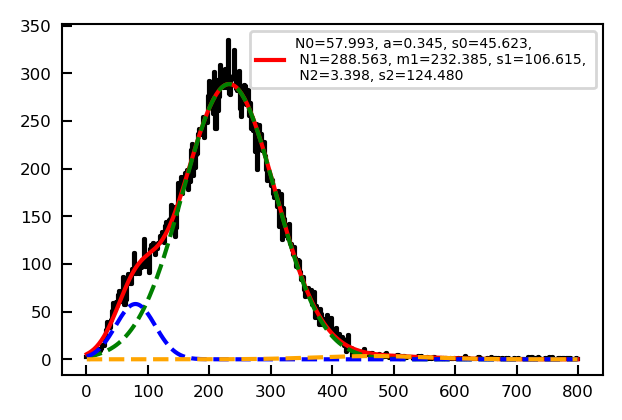

----------------------------
1589635932.000852
1  Fit Parameters:
SPE peak:  232.38542260176473 \pm 0.6149666126757616
chi^2/Ndof =  1.5089023119553568
1 sigma interval rate =  231.54  events/s
----------------------------
1589636032.000136
2  Fit Parameters:
SPE peak:  234.1737779737554 \pm 0.6827478182166752
chi^2/Ndof =  1.6889873682097434
1 sigma interval rate =  232.62  events/s
----------------------------
1589636132.0043557
3  Fit Parameters:
SPE peak:  230.74265324619168 \pm 0.5060632521973005
chi^2/Ndof =  1.8303705358838043
1 sigma interval rate =  237.81  events/s
----------------------------
1589636232.0007353
4  Fit Parameters:
SPE peak:  233.22881048147713 \pm 0.6364772679508883
chi^2/Ndof =  1.3984903956444235
1 sigma interval rate =  233.04  events/s
----------------------------
1589636332.0013747
5  Fit Parameters:
SPE peak:  232.46696814943343 \pm 0.6085522525796532
chi^2/Ndof =  1.576648073976641
1 sigma interval rate =  233.57  events/s
----------------------------


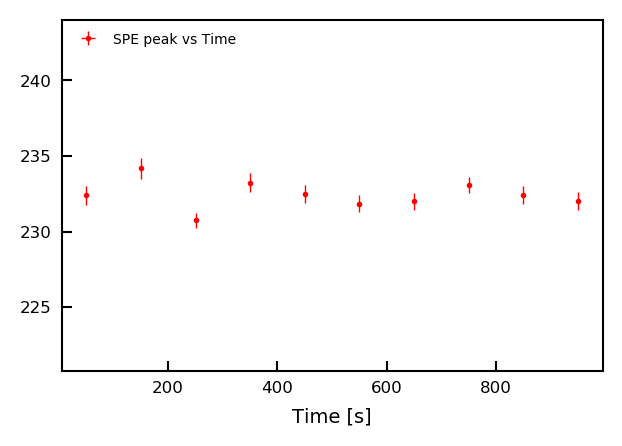

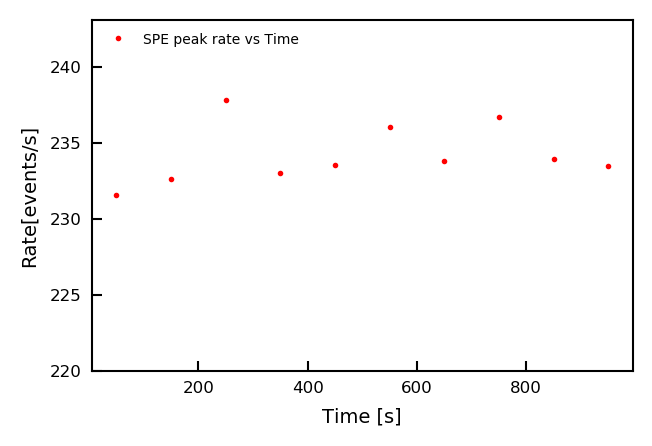

[ 56.76583625   0.3386816   46.51232484 290.57827007 233.58521707
 107.16859406   2.03568053  81.96402161]
[2.56579341e+00 7.16383173e-03 2.61201366e+00 1.49448606e+00
 6.09764538e-01 1.06612863e+00 1.60646821e+00 8.86539383e+01]


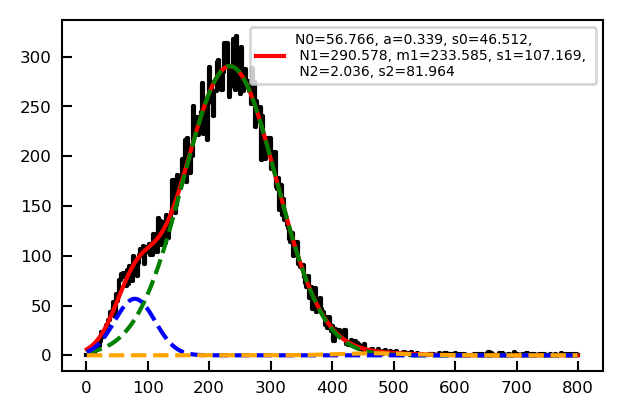

----------------------------
1589639562.0008361
1  Fit Parameters:
SPE peak:  233.58521707310453 \pm 0.6097645382680501
chi^2/Ndof =  2.052289149557738
1 sigma interval rate =  234.18  events/s
----------------------------
1589639662.0036426
2  Fit Parameters:
SPE peak:  232.49023879398518 \pm 0.5064382260657755
chi^2/Ndof =  1.2795193601889125
1 sigma interval rate =  233.82  events/s
----------------------------
1589639762.0032558
3  Fit Parameters:
SPE peak:  233.02171720134038 \pm 0.49723007493432764
chi^2/Ndof =  1.1841149261757833
1 sigma interval rate =  235.89  events/s
----------------------------
1589639862.0008612
4  Fit Parameters:
SPE peak:  232.4331967627472 \pm 0.6524819830137157
chi^2/Ndof =  2.1318765881693835
1 sigma interval rate =  232.49  events/s
----------------------------
1589639962.0008166
5  Fit Parameters:
SPE peak:  230.7534932605566 \pm 0.607536949336191
chi^2/Ndof =  2.2858074025713404
1 sigma interval rate =  237.3  events/s
----------------------------


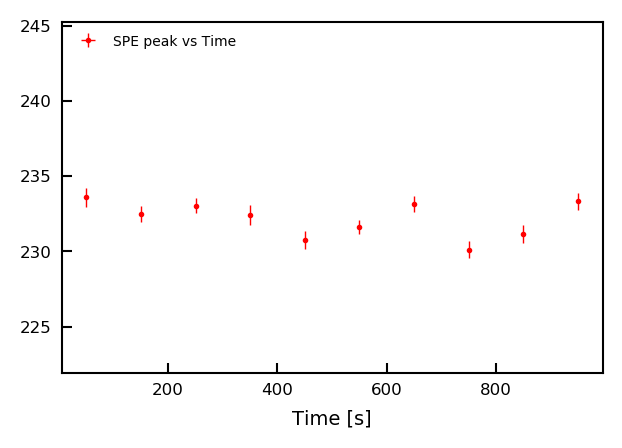

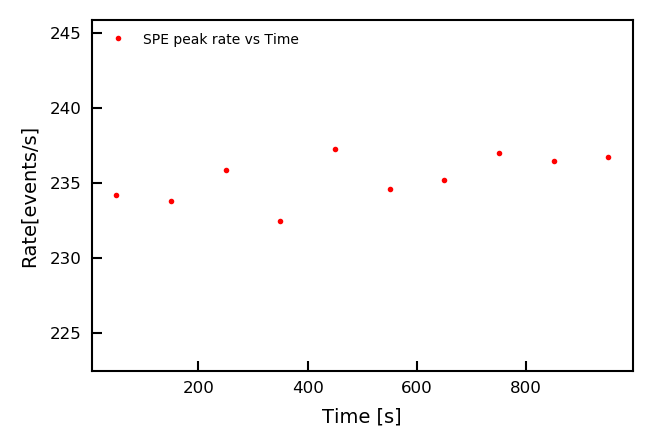

In [58]:
runs = ['007730','007731','007732']
for i in runs:
    channel_check(i,'channel == 320',True)

## Example with Loop on Channel

[ 59.28008017   0.34272     43.93386458 289.06197084 233.29174053
 108.16917572   2.15464417  68.01954663]
[2.66713499e+00 6.57552842e-03 2.43859949e+00 1.52630918e+00
 6.10523910e-01 1.05125205e+00 1.79947707e+00 7.37679422e+01]


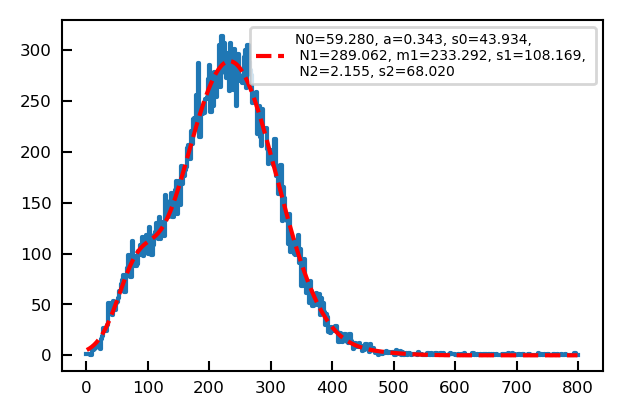

----------------------------
1589632300.0000744
1  Fit Parameters:
SPE peak:  233.29174053000895 \pm 0.6105239096437923
chi^2/Ndof =  1.4592290870005802
1 sigma interval rate =  235.27  events/s
----------------------------
1589632400.0016305
2  Fit Parameters:
SPE peak:  232.75151886385052 \pm 0.5950837760702263
chi^2/Ndof =  2.164266722656381
1 sigma interval rate =  234.25  events/s
----------------------------
1589632500.0095732
3  Fit Parameters:
SPE peak:  231.11652326526018 \pm 0.4928223409666175
chi^2/Ndof =  1.2589892388557746
1 sigma interval rate =  235.96  events/s
----------------------------
1589632600.0112813
4  Fit Parameters:
SPE peak:  232.69377305757592 \pm 0.6503085144164461
chi^2/Ndof =  1.2000683201047206
1 sigma interval rate =  231.0  events/s
----------------------------
1589632700.001573
5  Fit Parameters:
SPE peak:  234.60321936359793 \pm 0.5406717316946789
chi^2/Ndof =  1.6548750929960803
1 sigma interval rate =  232.88  events/s
----------------------------

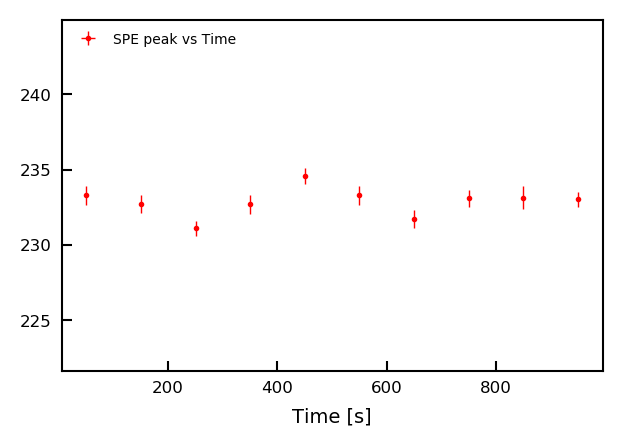

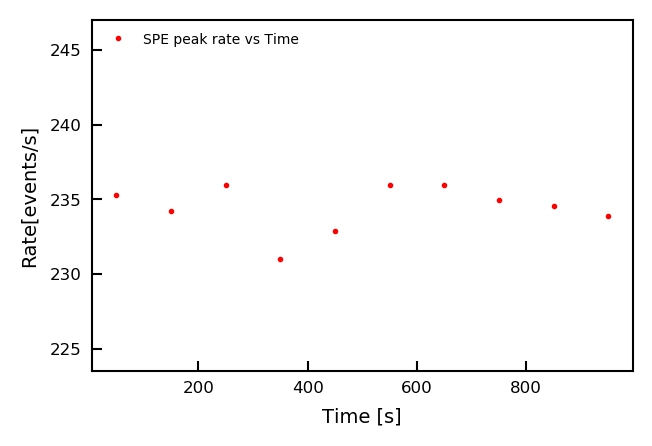

[1.09791966e+02 3.19967876e-01 5.38005638e+01 4.77808717e+02
 2.64661806e+02 1.20658736e+02 3.21661728e+00 1.77952288e+02]
[2.93241413e+00 4.49825890e-03 1.85601925e+00 2.09779373e+00
 5.13122139e-01 8.14563310e-01 1.53952106e+00 1.23809448e+02]


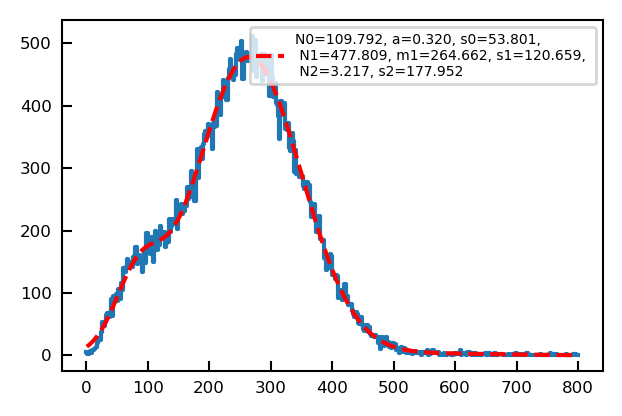

----------------------------
1589632300.0010974
1  Fit Parameters:
SPE peak:  264.66180551506017 \pm 0.5131221385585196
chi^2/Ndof =  2.1336201847303324
1 sigma interval rate =  434.52  events/s
----------------------------
1589632400.0035846
2  Fit Parameters:
SPE peak:  265.1488398857871 \pm 0.4466053491426239
chi^2/Ndof =  2.1782567169765232
1 sigma interval rate =  432.41  events/s
----------------------------
1589632500.000567
3  Fit Parameters:
SPE peak:  263.7086667235489 \pm 0.4031877976866564
chi^2/Ndof =  1.7072107167453687
1 sigma interval rate =  433.41  events/s
----------------------------
1589632600.0006113
4  Fit Parameters:
SPE peak:  264.5285473094371 \pm 0.5537326229905534
chi^2/Ndof =  1.631001500602522
1 sigma interval rate =  429.61  events/s
----------------------------
1589632700.0016232
5  Fit Parameters:
SPE peak:  263.54880912855094 \pm 0.4813936386002505
chi^2/Ndof =  2.032501210668163
1 sigma interval rate =  432.2  events/s
----------------------------
158

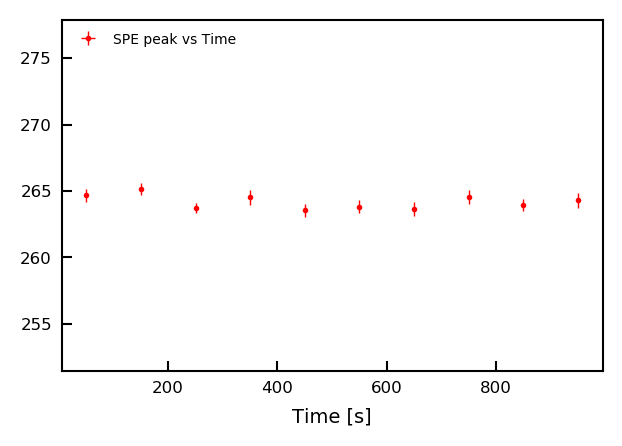

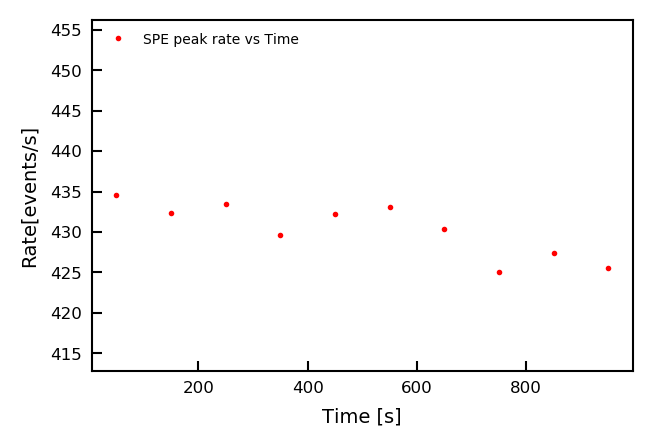

[4.42739437e+02 2.86989378e-01 6.24033832e+01 1.39403369e+03
 3.34464881e+02 1.43017364e+02 7.91692033e+00 8.38282783e+01]
[5.47716032e+00 1.98628741e-03 1.01978691e+00 3.65705504e+00
 3.39032736e-01 5.63805505e-01 4.57955077e+00 6.04532427e+01]


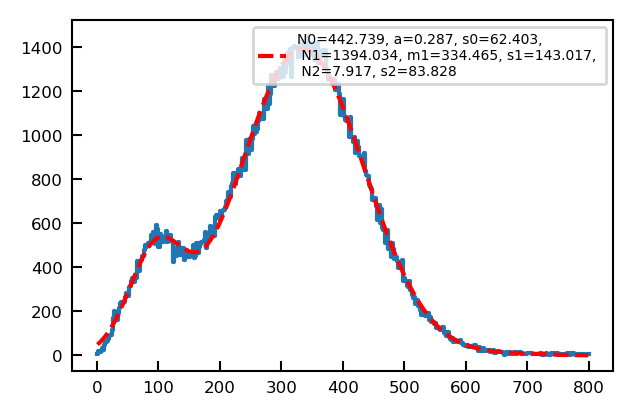

----------------------------
1589632300.0004978
1  Fit Parameters:
SPE peak:  334.46488096690365 \pm 0.3390327357574784
chi^2/Ndof =  3.507759092013869
1 sigma interval rate =  1493.73  events/s
----------------------------
1589632400.0001535
2  Fit Parameters:
SPE peak:  335.49805080456775 \pm 0.3508883477334546
chi^2/Ndof =  3.470542827956392
1 sigma interval rate =  1487.68  events/s
----------------------------
1589632500.0003338
3  Fit Parameters:
SPE peak:  335.24629388545776 \pm 0.3469531216595574
chi^2/Ndof =  3.5225939070280328
1 sigma interval rate =  1484.24  events/s
----------------------------
1589632600.0024915
4  Fit Parameters:
SPE peak:  335.07576826040753 \pm 0.3396183619645698
chi^2/Ndof =  3.5708527384844646
1 sigma interval rate =  1479.82  events/s
----------------------------
1589632700.0003097
5  Fit Parameters:
SPE peak:  335.130390547222 \pm 0.3339225294422361
chi^2/Ndof =  3.080037030290943
1 sigma interval rate =  1489.95  events/s
-------------------------

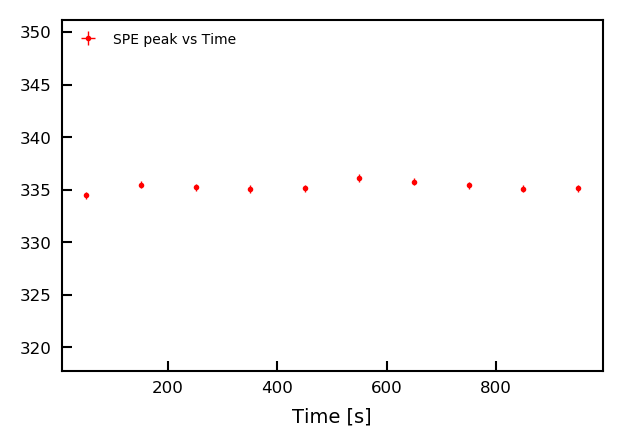

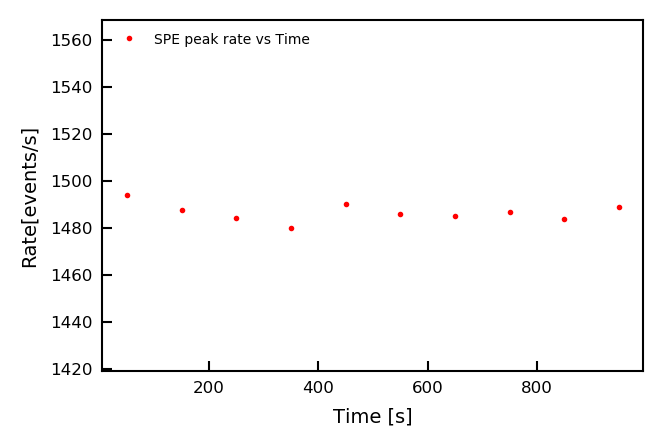

In [31]:
channels = ['channel == 320','channel == 321','channel == 322']
for i in channels:
    channel_check(run_id,i,True)